# Modelling

We will experiment with different preprocessing functions and different classifiers to find the best performing model.

In [1]:
print ('loading libraries...')
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import utils
import config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [2]:
#load dataset
filename = 'facies_data.csv'
data = pd.read_csv(filename)
data = data.drop_duplicates().reset_index(drop=True)
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3226,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3227,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3228,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3229,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [3]:
test_well_data = data[data['Well Name'] == 'CHURCHMAN BIBLE']

In [4]:
train, test = utils.train_test_split_by_well(data, config.TRAIN_SIZE)
train.shape, test.shape

((2714, 11), (517, 11))

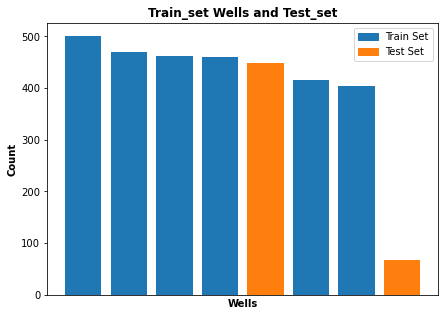

In [5]:
utils.train_test_plot(data, train, test)

In [6]:
train = train.drop(['Well Name', 'Formation', 'Depth'], axis =1)
test = test.drop(['Well Name', 'Formation', 'Depth'], axis =1)

In [7]:
train_X = train.drop('Facies', axis = 1)
train_y = train.Facies
test_X = test.drop('Facies', axis = 1)
test_y = test.Facies
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2714, 7), (2714,), (517, 7), (517,))

In [8]:
def create_pipeline(clf, transformer, train_X, train_y):
    pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('clf', clf)
        ]
    )
    pipeline.fit(train_X, train_y)

    return pipeline


def pipeline_acc_score(pipeline, test_X, test_y):
    preds = pipeline.predict(test_X)

    acc_score_pipeline = accuracy_score(test_y, preds)

    return acc_score_pipeline

In [9]:
def evaluate_model(models, preprocessors, train_X, train_y, test_X, test_y):
    models_list = []
    transformer = []
    accuracy = []
    for model in models:
        for preprocessor in preprocessors:
            pipeline = create_pipeline(model, preprocessor, train_X, train_y)
            model_acc_score = pipeline_acc_score(pipeline, test_X, test_y)
            models_list.append(model)
            transformer.append(preprocessor)
            accuracy.append(round(model_acc_score, 2))
    models_evaluation_list = []
    [models_evaluation_list.append([model, preprocessor, accuracy]) 
    for model, preprocessor, accuracy in zip( models_list, transformer, accuracy)]
    # models_evaluation_list = [[models_list, transformer, accuracy]]
    models_evaluation_df = pd.DataFrame(
        models_evaluation_list, 
        columns = ['models', 'transformers', 'accuracy']
    )
    return models_evaluation_df

In [10]:
results = evaluate_model(config.MODELS, config.PREPROCESSORS, train_X, train_y, test_X, test_y)
results

[00:03:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

,models,transformers,accuracy
0,LogisticRegression(),Normalizer(),0.35
1,LogisticRegression(),MinMaxScaler(),0.37
2,LogisticRegression(),StandardScaler(),0.50
3,LogisticRegression(),PowerTransformer(),0.51
4,"(ExtraTreeClassifier(random_state=1453709154),...",Normalizer(),0.53
5,"(ExtraTreeClassifier(random_state=1453709154),...",MinMaxScaler(),0.58
6,"(ExtraTreeClassifier(random_state=1453709154),...",StandardScaler(),0.58
7,"(ExtraTreeClassifier(random_state=1453709154),...",PowerTransformer(),0.58
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",Normalizer(),0.52
9,"XGBClassifier(base_score=0.5, booster='gbtree'...",MinMaxScaler(),0.52


In [11]:
# grid search XTC pipeline
from sklearn.model_selection import GridSearchCV
parameters = {
    'clf__n_estimators': [10, 20, 30, 40, 60, 80,],
    'clf__max_depth': [15, 20, 25, 30, 40, 50]
}

cv = [(slice(None), slice(None))]

pipeline = Pipeline(
        [
            ('transformer', MinMaxScaler()),
            ('clf', ExtraTreesClassifier())
        ]
    )

gs_xtc = GridSearchCV(pipeline, parameters, cv=cv, verbose=True)

gs_xtc.fit(train_X, train_y)

gs_xtc_clf_pred = gs_xtc.predict(test_X)

best_parameters = gs_xtc.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 1 folds for each of 36 candidates, totalling 36 fits
	clf__max_depth: 20
	clf__n_estimators: 20


In [12]:
model = ExtraTreesClassifier(random_state=16)
model.fit(train_X, train_y)

ExtraTreesClassifier(random_state=16)

In [13]:
predictions = model.predict(test_X)
acc_metrics = accuracy_score(test_y, predictions)
acc_metrics

0.5822050290135397